In [2]:
import matplotlib
# matplotlib.use('Agg')  # Or any other X11 back-end   
import numpy as np
import torch.nn as nn
import torch.nn.init as init

  
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import signal
import time
import torch
import torch.nn as nn
from torch.autograd import Variable

import h5py
import numpy as np
import os
import pandas as pd
from torch.utils.data import Dataset
import wfdb

%matplotlib inline

In [143]:
class SleepDatasetValid(Dataset):
    """Physionet 2018 dataset."""

    def __init__(self, records_file, root_dir, s, f, window_size, hanning_window):
        """
        Args:
            records_file (string): Path to the records file.
            root_dir (string): Directory with all the signals.

        """
        self.landmarks_frame = pd.read_csv(records_file)[s:f]
        self.root_dir = root_dir
        self.window_size = window_size
        self.hw = hanning_window
        self.num_bins = window_size//hanning_window

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        folder_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        file_name = self.landmarks_frame.iloc[idx, 0]
#         print(file_name)
#         print(folder_name)
#         file_name='tr03-0005/'
#         folder_name='../data/training/tr03-0005/'
        signals = wfdb.rdrecord(os.path.join(folder_name, file_name[:-1]))
        arousals = h5py.File(os.path.join(folder_name, file_name[:-1] + '-arousal.mat'), 'r')
        tst_ann = wfdb.rdann(os.path.join(folder_name, file_name[:-1]), 'arousal')
        
        positive_indexes = []
        negative_indexes = []
        
        arous_data = arousals['data']['arousals'].value.ravel()
        
        for w in range(len(arous_data)//self.window_size):
            if arous_data[w*self.window_size:(w+1)*self.window_size].max() > 0:
                positive_indexes.append(w)
            else:
                negative_indexes.append(w)
        
#             max_in_window = arous_data[].max()
        if len(positive_indexes) < len(negative_indexes):
            windexes = np.append(positive_indexes, np.random.choice(negative_indexes, len(positive_indexes)//10, replace=False))
        else:
            windexes = np.append(negative_indexes, np.random.choice(positive_indexes, len(negative_indexes), replace=False))
        windexes = np.sort(windexes)
        
        labels = []
        total = 0
        positive = 0
        for i in windexes:
            tmp = []
            window_s = i*self.window_size
            window_e = (i+1)*self.window_size
            for j in range(self.num_bins):
                total += 1
                bin_s = j*self.hw + window_s
                bin_e = (j+1)*self.hw + window_s
                if arous_data[bin_s:bin_e].max() > 0:
                    tmp.append(1)
                    positive += 1
                else:
                    tmp.append(0)
            labels.append(tmp)
#         print('sample percent ratio: {:.2f}'.format(positive/total))
        interested = []
        for i in range(13):
            signals.p_signal[:,i] = (signals.p_signal[:,i] - signals.p_signal[:,i].mean())/ signals.p_signal[:,i].std()
            if signals.sig_name[i] in ['ABD', 'F3-M2']:#, 'ABD', 'F4-M1', 'C4-M1', 'O2-M1', 'AIRFLOW']:
                interested.append(i)
#         POI = arousal_centers
        sample =  ((signals.p_signal[:,interested], windexes), arous_data)
        return sample

In [144]:
class SleepDataset(Dataset):
    """Physionet 2018 dataset."""

    def __init__(self, records_file, root_dir, s, f, window_size, hanning_window, validation=False):
        """
        Args:
            records_file (string): Path to the records file.
            root_dir (string): Directory with all the signals.

        """
        self.landmarks_frame = pd.read_csv(records_file)[s:f]
        self.root_dir = root_dir
        self.window_size = window_size
        self.hw = hanning_window
        self.num_bins = window_size//hanning_window
        
        self.validation=validation
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        np.random.seed(12345)
        folder_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        file_name = self.landmarks_frame.iloc[idx, 0]
#         print(file_name)
#         print(folder_name)
#         file_name='tr03-0005/'
#         folder_name='../data/training/tr03-0005/'
        signals = wfdb.rdrecord(os.path.join(folder_name, file_name[:-1]))
        arousals = h5py.File(os.path.join(folder_name, file_name[:-1] + '-arousal.mat'), 'r')
        tst_ann = wfdb.rdann(os.path.join(folder_name, file_name[:-1]), 'arousal')
        
        positive_indexes = []
        negative_indexes = []
        
        arous_data = arousals['data']['arousals'].value.ravel()
        
        for w in range(len(arous_data)//self.window_size):
            if arous_data[w*self.window_size:(w+1)*self.window_size].max() > 0:
                positive_indexes.append(w)
            else:
                negative_indexes.append(w)
        
#             max_in_window = arous_data[].max()
        
        if self.validation:
            windexes = np.append(positive_indexes, negative_indexes)
        else: 
            if len(positive_indexes) < len(negative_indexes):
                windexes = np.append(positive_indexes, np.random.choice(negative_indexes, len(positive_indexes), replace=False))
            else:
                windexes = np.append(negative_indexes, np.random.choice(positive_indexes, len(negative_indexes), replace=False))
            windexes = np.sort(windexes)
#         windexes = np.array(positive_indexes)
        labels = []
        total = 0
        positive = 0
        for i in windexes:
            tmp = []
            window_s = i*self.window_size
            window_e = (i+1)*self.window_size
            for j in range(self.num_bins):
                total += 1
                bin_s = j*self.hw + window_s
                bin_e = (j+1)*self.hw + window_s
                if arous_data[bin_s:bin_e].max() > 0:
                    positive += 1
                    tmp.append(1.)
                else:
                    tmp.append(0.)
            labels.append(tmp)
        
        interested = []
#         print('# sample positive: {:.2f} #'.format(positive/total))
        for i in range(13):
            if signals.sig_name[i] in ['ABD', 'F3-M2']:#, 'ABD', 'F4-M1', 'C4-M1', 'O2-M1', 'AIRFLOW']:
                interested.append(i)
            signals.p_signal[:,i] = (signals.p_signal[:,i] - signals.p_signal[:,i].mean())/ signals.p_signal[:,i].std()
#         POI = arousal_centers
#         tst_sig = np.random.rand(len(signals.p_signal[:,interested]),13)
        sample =  ((signals.p_signal[:,interested], windexes), np.array(labels))
#         sample =  ((tst_sig, windexes), np.array(labels))
        return sample

In [145]:
class Model_V3(nn.Module):

    def __init__(self, window_size, han_size):
        super(Model_V3, self).__init__()
        num_bins = window_size//han_size
        
        self.cnn1 = nn.Conv1d(2, 16, 3, padding=1)
        init.xavier_uniform(self.cnn1.weight, gain=nn.init.calculate_gain('relu'))
        init.constant(self.cnn1.bias, 0.1)
        
        self.cnn2 = nn.Conv1d(16, 16, 3, padding=1)
        init.xavier_uniform(self.cnn2.weight, gain=nn.init.calculate_gain('relu'))
        init.constant(self.cnn2.bias, 0.1)
        
        self.cnn3 = nn.Conv1d(16, 32, 3, padding=1)
        init.xavier_uniform(self.cnn3.weight, gain=nn.init.calculate_gain('relu'))
        init.constant(self.cnn3.bias, 0.1)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(8, 8)
        
        self.ap = nn.AdaptiveMaxPool1d(1)
        
        self.output = nn.Linear(32, num_bins)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.relu(self.pool(self.cnn1(torch.transpose(x, 1, 2))))
        x = self.relu(self.pool(self.cnn2(x)))
        x = self.relu(self.pool(self.cnn3(x)))
        x = self.ap(x)
        x = self.output(x.view(-1))
        return self.sigmoid(x)
        

In [153]:
minutes = 2
raw_window_size = minutes*60*200
hanning_window = 200*20#1024
print(hanning_window)
window_size = raw_window_size #+ (hanning_window - (raw_window_size + hanning_window) % hanning_window)
print('adjusted window size: {}, num bins: {}'.format(window_size, window_size//hanning_window))
output_pixels = ((window_size//hanning_window * (hanning_window//2+1))//64)*16
print('FC # params: {}'.format(output_pixels*window_size//hanning_window))
learning_rate = 1e-3

def to_spectogram(matrix):
    spectograms = []
    for i in range(all_data.size()[2]):
        f, t, Sxx = signal.spectrogram(matrix[0,:,i].numpy(), 
                           window=signal.get_window('hann',hanning_window, False), 
                           fs=200, 
                           scaling='density', 
                           mode='magnitude',
                           noverlap=0
                          )
        if (Sxx.min() != 0 or Sxx.max() != 0):
            spectograms.append((Sxx - Sxx.mean()) / Sxx.std())
        else:
            spectograms.append(Sxx)
    return torch.FloatTensor(spectograms).unsqueeze(0).cuda()

#TODO add torch.save(the_model.state_dict(), PATH) this to save the best models weights

train_dataset = SleepDataset('/beegfs/ga4493/projects/groupb/data/training/RECORDS', 
                             '/beegfs/ga4493/projects/groupb/data/training/', 20, 21, window_size, hanning_window)

train_loaders = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           shuffle=True)

test_dataset = SleepDataset('/beegfs/ga4493/projects/groupb/data/training/RECORDS', 
                                '/beegfs/ga4493/projects/groupb/data/training/', 0, 1, window_size, hanning_window, validation=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=1, 
                                          shuffle=False)

4000
adjusted window size: 24000, num bins: 6
FC # params: 17952


In [154]:
model_v1 = Model_V3(window_size, hanning_window)

if torch.cuda.is_available():
    print('using cuda')
    model_v1.cuda()

criterion = nn.BCELoss()#size_average=False)

optimizer = torch.optim.Adam(model_v1.parameters(), lr=learning_rate)

sig = nn.Sigmoid()

# i, ((data, cent), v_l) = next(enumerate(test_loader))
losses = []
v_losses = []
accuracy = []
v_accuracy = []
l = None
for epoch in range(15):
    loss_t = 0.0
    acc_t = 0.0
    count_t = 0
    start_time = time.time()
    val_l = None
    v_out = None
    v_all = []
    for c, ((all_data, windexes), labels) in enumerate(train_loaders):
        for i, win in enumerate(windexes.numpy()[0]):
            inp_subs = Variable(all_data[:,win*window_size:(win+1)*window_size,].type(torch.FloatTensor).cuda())
            l = None
            l = labels[0, i].type(torch.FloatTensor)
            if torch.cuda.is_available():
                l = l.cuda()
            l = Variable(l)
            
            output = model_v1(inp_subs)
#             print(output)
#             print(l)
            loss = criterion(output, l)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_t += loss.data[0]
            
            comparison = (output.cpu().data.numpy().ravel() > 0.5) == (l.cpu().data.numpy())
            acc_t += comparison.sum() / (window_size//hanning_window)
            
            count_t += 1
#             break
#         break
#     break
    losses.append(loss_t/count_t)
    accuracy.append(acc_t/count_t)
    
    loss_v = 0.0
    acc_v = 0.0
    count_v = 0
    for c, ((data, windexes), v_l) in enumerate(test_loader):
        for i, win in enumerate(windexes.numpy()[0]):
            inp_subs = Variable(data[:,win*window_size:(win+1)*window_size,].type(torch.FloatTensor).cuda())
            l = None
            l = v_l[0, i].type(torch.FloatTensor)
            if torch.cuda.is_available():
                l = l.cuda()
            l = Variable(l)
            output = model_v1(inp_subs)
            loss = criterion(output, l)

            loss_v += loss.data[0]
            count_v += 1
            
            comparison = (output.cpu().data.numpy().ravel() > 0.5) == (l.cpu().data.numpy())
            acc_v += comparison.sum() / (window_size//hanning_window)
            
    v_losses.append(loss_v/count_v)
    v_accuracy.append(acc_v/count_v)
    print('#'*45)
    print('# epoch  - {:>10} | time(s) -{:>10.2f} #'.format(epoch, time.time() - start_time))
    print('# T loss - {:>10.2f} | V loss - {:>10.2f} #'.format(loss_t/count_t, loss_v/count_v))
    print('# T acc  - {:>10.2f} | V acc  - {:>10.2f} #'.format(acc_t/count_t, acc_v/count_v))
print('#'*45)


using cuda
#############################################
# epoch  -          0 | time(s) -      9.27 #
# T loss -       0.60 | V loss -       0.50 #
# T acc  -       0.77 | V acc  -       0.80 #
#############################################
# epoch  -          1 | time(s) -      9.27 #
# T loss -       0.56 | V loss -       0.50 #
# T acc  -       0.80 | V acc  -       0.80 #
#############################################
# epoch  -          2 | time(s) -      9.28 #
# T loss -       0.56 | V loss -       0.49 #
# T acc  -       0.80 | V acc  -       0.80 #
#############################################
# epoch  -          3 | time(s) -      9.28 #
# T loss -       0.54 | V loss -       0.49 #
# T acc  -       0.80 | V acc  -       0.80 #
#############################################
# epoch  -          4 | time(s) -      9.30 #
# T loss -       0.53 | V loss -       0.49 #
# T acc  -       0.81 | V acc  -       0.80 #
#############################################
# epoch  -          5 |

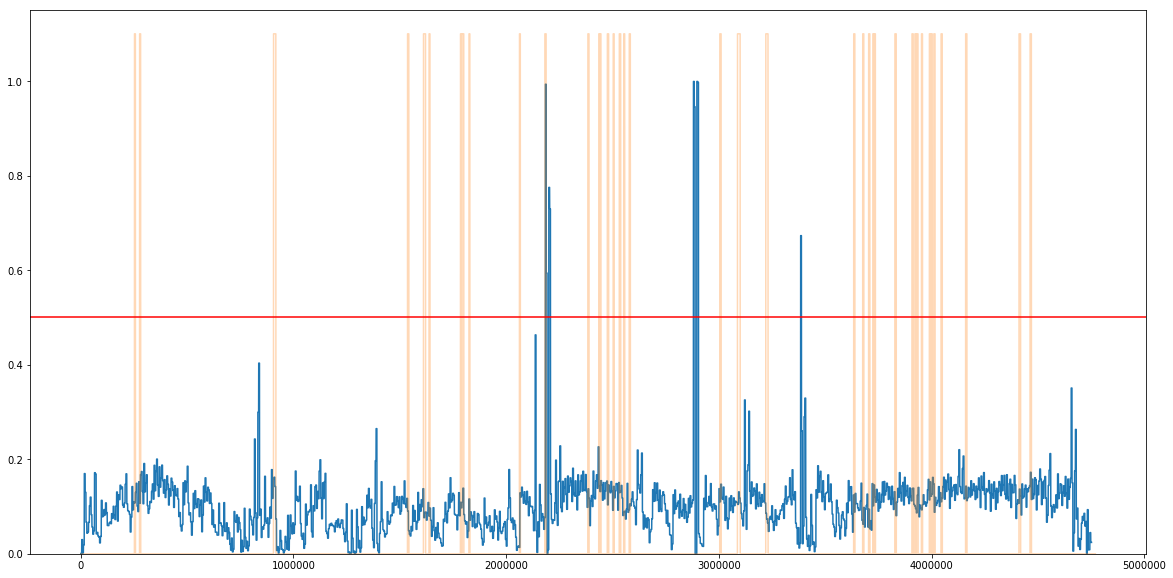

In [156]:
v_dataset = SleepDatasetValid('/beegfs/ga4493/projects/groupb/data/training/RECORDS', 
                                '/beegfs/ga4493/projects/groupb/data/training/', 0, 1, window_size, hanning_window)

v_loader = torch.utils.data.DataLoader(dataset=v_dataset, 
                                          batch_size=1, 
                                          shuffle=False)
start = 500000
stop = 1500000
ones = np.ones(hanning_window)
# plt.plot(all_data.cpu().view(-1).numpy())
# plt.show()

for c, ((data, windexes), v_l) in enumerate(v_loader):
    out_for_plot = []
    for i in range((data.size()[1]//window_size)):
#     for i in range((start//window_size), (stop//window_size)):
        inp_subs = Variable(data[:,i*window_size:(i+1)*window_size,].type(torch.FloatTensor).cuda())
        output = model_v1(inp_subs).cpu().data.numpy()
        out_for_plot = np.append(out_for_plot, output)
    out_for_plot = np.repeat(out_for_plot, hanning_window)
    f = plt.figure(figsize=(20, 10))
    plt.plot(out_for_plot)
    plt.plot((v_l.numpy()[0][:len(v_l.numpy()[0])] > 0).astype(float)*1.1, alpha=0.3)
#     plt.plot((v_l.numpy()[0][:len(v_l.numpy()[0])] < 0).astype(float)*1.1, alpha=0.3)
#     plt.plot((v_l.numpy()[0][(start): (stop)] > 0).astype(float)*1.1, alpha=0.3)
#     plt.plot((v_l.numpy()[0][(start): (stop)] < 0).astype(float)*1.1, alpha=0.3)
    plt.ylim((0,1.15))
    plt.axhline(y=0.5, color='r', linestyle='-')
    plt.show()

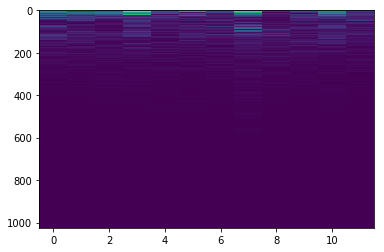

In [113]:
plt.imshow(inp_subs.cpu().squeeze(0).squeeze(0).data.numpy(), aspect='auto')


In [38]:
output

array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.], dtype=float32)